In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts


from mne_connectivity import spectral_connectivity_epochs
from mne.datasets import sample
import seaborn as sns

from scipy.signal import welch
import yasa
import constants
import numpy as np

#PCA Imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

#Pipeline
from sklearn.pipeline import Pipeline

# !{sys.executable} -m pip install umap-learn

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))


In [2]:
import umap

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/user/home/ko20929/.conda/envs/sktime_latest/lib/p

In [3]:
power_bands = {'delta' : (0.5,4) , 'theta' : (4,8) , 'alpha' : (8,12) , 'sigma' : (12,16) , 'beta' : (16,30) , 'gamma' : (30,40) }
power_band_names = [val for val in power_bands.keys()]
data_type = 'REM'
folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/Connectivity/'
X = pd.read_hdf(folder + data_type+ '_coherence_df.h5')
X = X.reset_index(drop = True)
y = pd.read_hdf('/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/C_22_data/Full_dfs/' + data_type + '_y.h5')
groups = pd.read_hdf('/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/C_22_data/Full_dfs/' + data_type + '_groups.h5')

In [23]:
3/2 *(3-1) * 6

18.0

In [ ]:
3 --> 2, 1 , 0 
4 --> 3, 2, 1, 0 
5--> 4,3,2,1,0

In [26]:
num_features = 6
within_features = num_features/2 * (num_features-1) * 6
within_features

90.0

In [28]:
num_features_1 = 4
num_features_2 = 5

In [34]:
sum = 0 
for i in range(14):
    sum+=i
sum

91

In [32]:
10000 / 169

59.171597633136095

In [33]:
60*169

10140

In [29]:
connected_features = num_features_1 * num_features_2

In [35]:
region_channel_dict = constants.region_to_channel_dict

In [22]:
(2+1) * 6

18

In [21]:
Prefrontal_channels = ['Fp1', 'Fpz', 'Fp2']
within_prefrontal_features = []
for i, channel in enumerate(Prefrontal_channels):
    for channel_2 in Prefrontal_channels[i:]:
        features = [col for col in X.columns if channel + '_' + channel_2 in col]
        within_prefrontal_features +=features
        
len(within_prefrontal_features)

18

In [5]:
reducer = umap.UMAP(random_state=42)

In [6]:
reducer.fit(X)

UMAP(random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

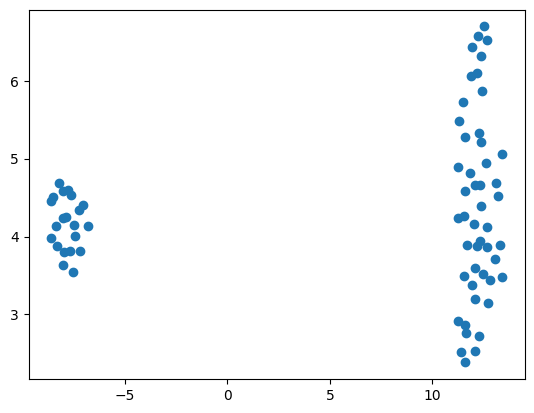

In [8]:
plt.scatter(transformed[:, 0] , transformed[:, 1])

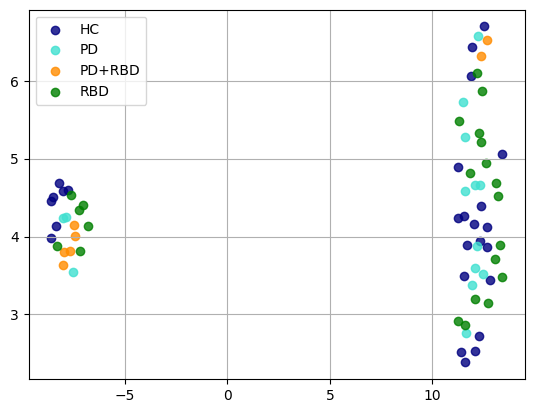

In [9]:
colors =  ['navy', 'turquoise', 'darkorange', 'green']
target_names = ['HC' , 'PD' , 'PD+RBD', 'RBD'] 

for color, i, target_name in zip(colors, [0, 1, 2,3], target_names):
    plt.scatter(transformed[y == i, 0], transformed[y == i, 1], color=color, alpha=0.8, label=target_name)
    plt.legend()
    
plt.grid()

## UMAP Clustering all together

<Figure size 640x480 with 0 Axes>

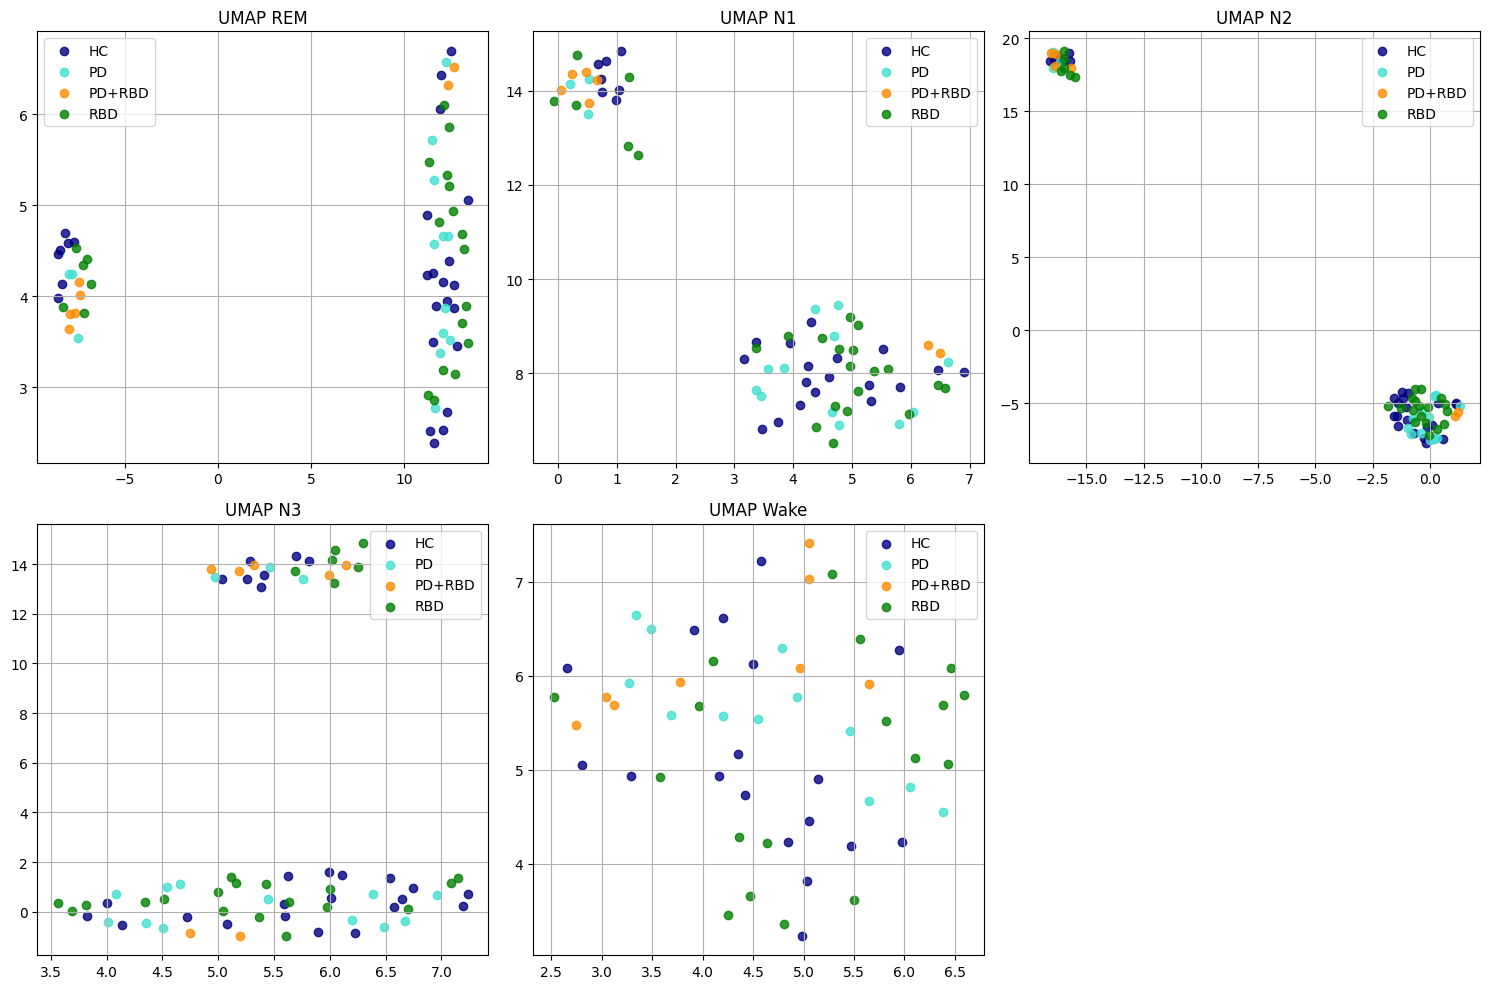

In [11]:
#Plot the graphs for all data types
fig = plt.figure()
fig = plt.figure(figsize=(15,10),dpi=100)

colors =  ['navy', 'turquoise', 'darkorange', 'green']
target_names = ['HC' , 'PD' , 'PD+RBD', 'RBD'] 

for i, data_type in enumerate(['REM', 'N1', 'N2', 'N3', 'Wake']):
    power_bands = {'delta' : (0.5,4) , 'theta' : (4,8) , 'alpha' : (8,12) , 'sigma' : (12,16) , 'beta' : (16,30) , 'gamma' : (30,40) }
    power_band_names = [val for val in power_bands.keys()]
    folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/Connectivity/'
    X = pd.read_hdf(folder + data_type+ '_coherence_df.h5')
    X = X.reset_index(drop = True)
    y = pd.read_hdf('/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/C_22_data/Full_dfs/' + data_type + '_y.h5')
    groups = pd.read_hdf('/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/C_22_data/Full_dfs/' + data_type + '_groups.h5')
    
    reducer = umap.UMAP(random_state=42)
    
    X_umap = reducer.fit_transform(X)
    
    ax = fig.add_subplot(2,3,i+1)
    
    plt.title('UMAP ' + data_type)

    for color, i, target_name in zip(colors, [0, 1, 2,3], target_names):
        plt.scatter(X_umap[y == i, 0], X_umap[y == i, 1], color=color, alpha=0.8, label=target_name)
        plt.legend()
    
    plt.grid()
    
    plt.tight_layout()

In [14]:
X[[col for col in X.columns if 'delta' in col]]

,delta_Fp1_Fpz,delta_Fp1_Fp2,delta_Fp1_F1,delta_Fp1_Fz,delta_Fp1_F2,delta_Fp1_AF7,delta_Fp1_F7,delta_Fp1_F5,delta_Fp1_F3,delta_Fp1_AF8,...,delta_PO8_POz,delta_PO8_O1,delta_PO8_O2,delta_PO8_Oz,delta_POz_O1,delta_POz_O2,delta_POz_Oz,delta_O1_O2,delta_O1_Oz,delta_O2_Oz
0,0.953931,0.520429,0.542333,0.348677,0.353381,0.489728,0.513477,0.532967,0.408000,0.344738,...,0.316697,0.747974,0.239791,0.266902,0.424922,0.519402,0.344664,0.320452,0.370634,0.296268
1,0.635187,0.621240,0.282571,0.185618,0.304530,0.367233,0.511230,0.328310,0.334714,0.629373,...,0.183993,0.909420,0.221061,0.421205,0.199004,0.742496,0.411731,0.313456,0.461539,0.444667
2,0.938134,0.870624,0.598293,0.338438,0.719192,0.784206,0.833546,0.781559,0.734922,0.567537,...,0.620684,0.862843,0.624020,0.280341,0.707522,0.910966,0.348569,0.788377,0.353385,0.421658
3,0.869746,0.716190,0.372368,0.341759,0.566200,0.555027,0.594524,0.396360,0.133127,0.527864,...,0.360230,0.815896,0.483019,0.322368,0.426672,0.804240,0.394204,0.644451,0.481791,0.507888
4,0.902964,0.597608,0.300778,0.323164,0.411252,0.577594,0.559308,0.536956,0.556156,0.422798,...,0.507319,0.742626,0.565226,0.341746,0.591075,0.911557,0.373695,0.693612,0.778102,0.442486
5,0.771525,0.573305,0.482682,0.350296,0.326987,0.662023,0.571990,0.643776,0.668972,0.463941,...,0.444807,0.932940,0.531424,0.254760,0.529556,0.941432,0.272606,0.638109,0.348323,0.329603
6,0.914142,0.719624,0.409281,0.282655,0.419215,0.609664,0.671082,0.681092,0.672646,0.514200,...,0.342734,0.793102,0.491418,0.218272,0.579186,0.880277,0.363279,0.698868,0.310599,0.408774
7,0.852841,0.412237,0.310094,0.375978,0.431138,0.580869,0.581404,0.618226,0.615990,0.379653,...,0.408278,0.797044,0.537669,0.214750,0.510220,0.755716,0.189009,0.719491,0.274949,0.278844
8,0.715879,0.600220,0.244397,0.139771,0.397500,0.464463,0.536555,0.354135,0.356950,0.671903,...,0.194733,0.754637,0.366598,0.303159,0.278540,0.656355,0.340209,0.449457,0.349958,0.894196
9,0.757792,0.594291,0.453150,0.338333,0.408027,0.534619,0.546304,0.519228,0.308320,0.318783,...,0.345157,0.825789,0.377139,0.341450,0.424617,0.692451,0.386820,0.469616,0.437392,0.427256


### UMAP Clustering by power band

<Figure size 640x480 with 0 Axes>

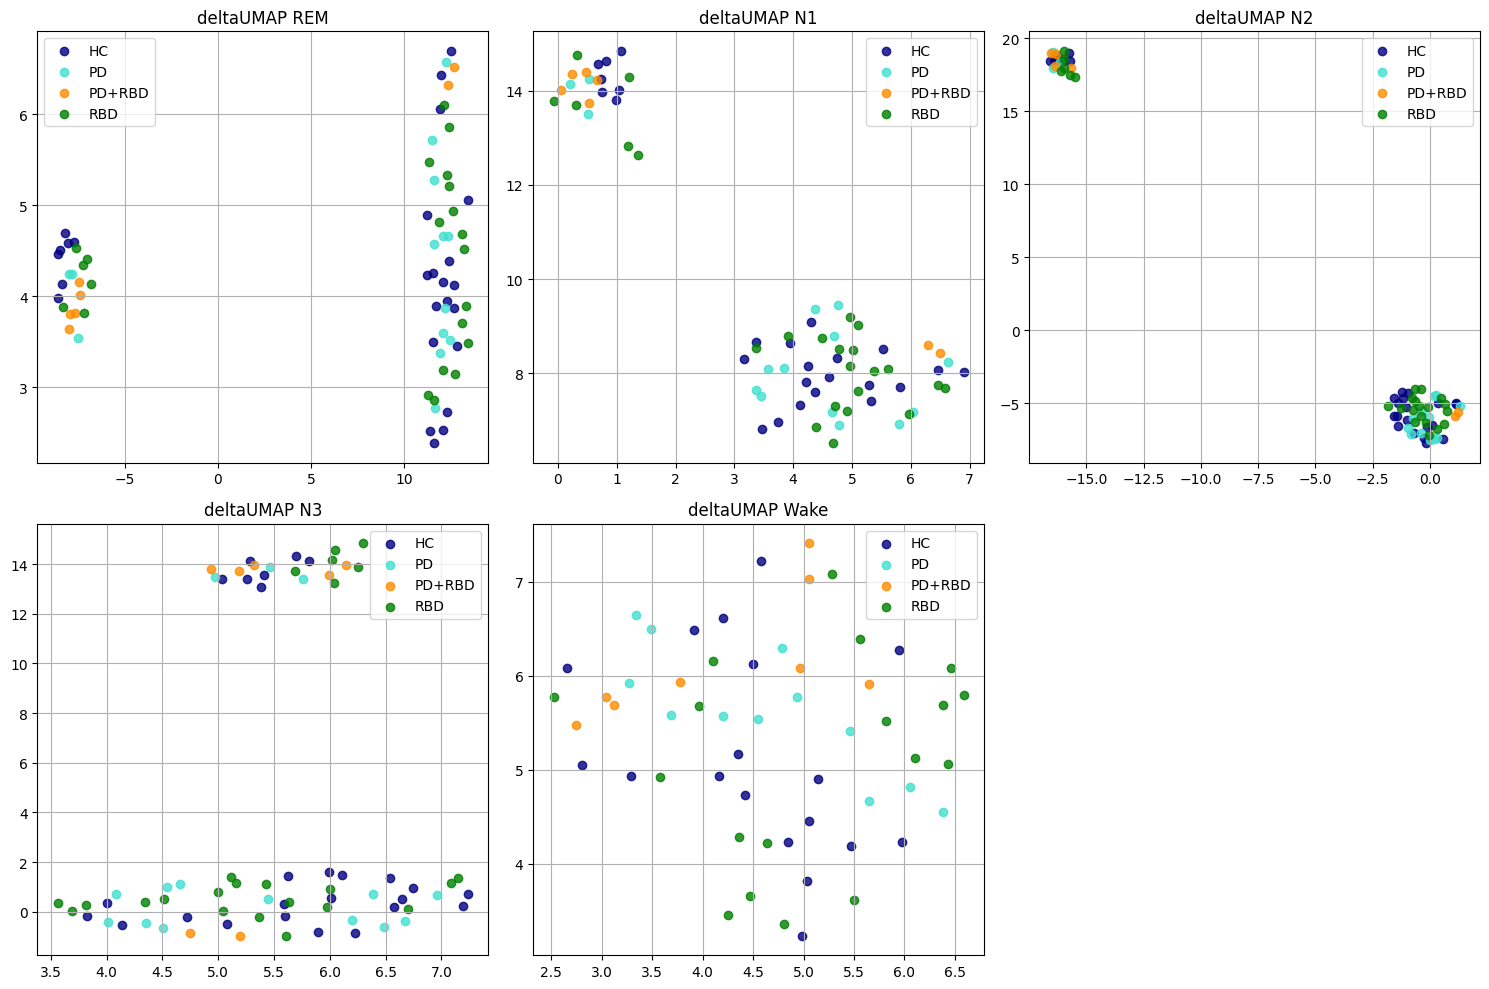

<Figure size 640x480 with 0 Axes>

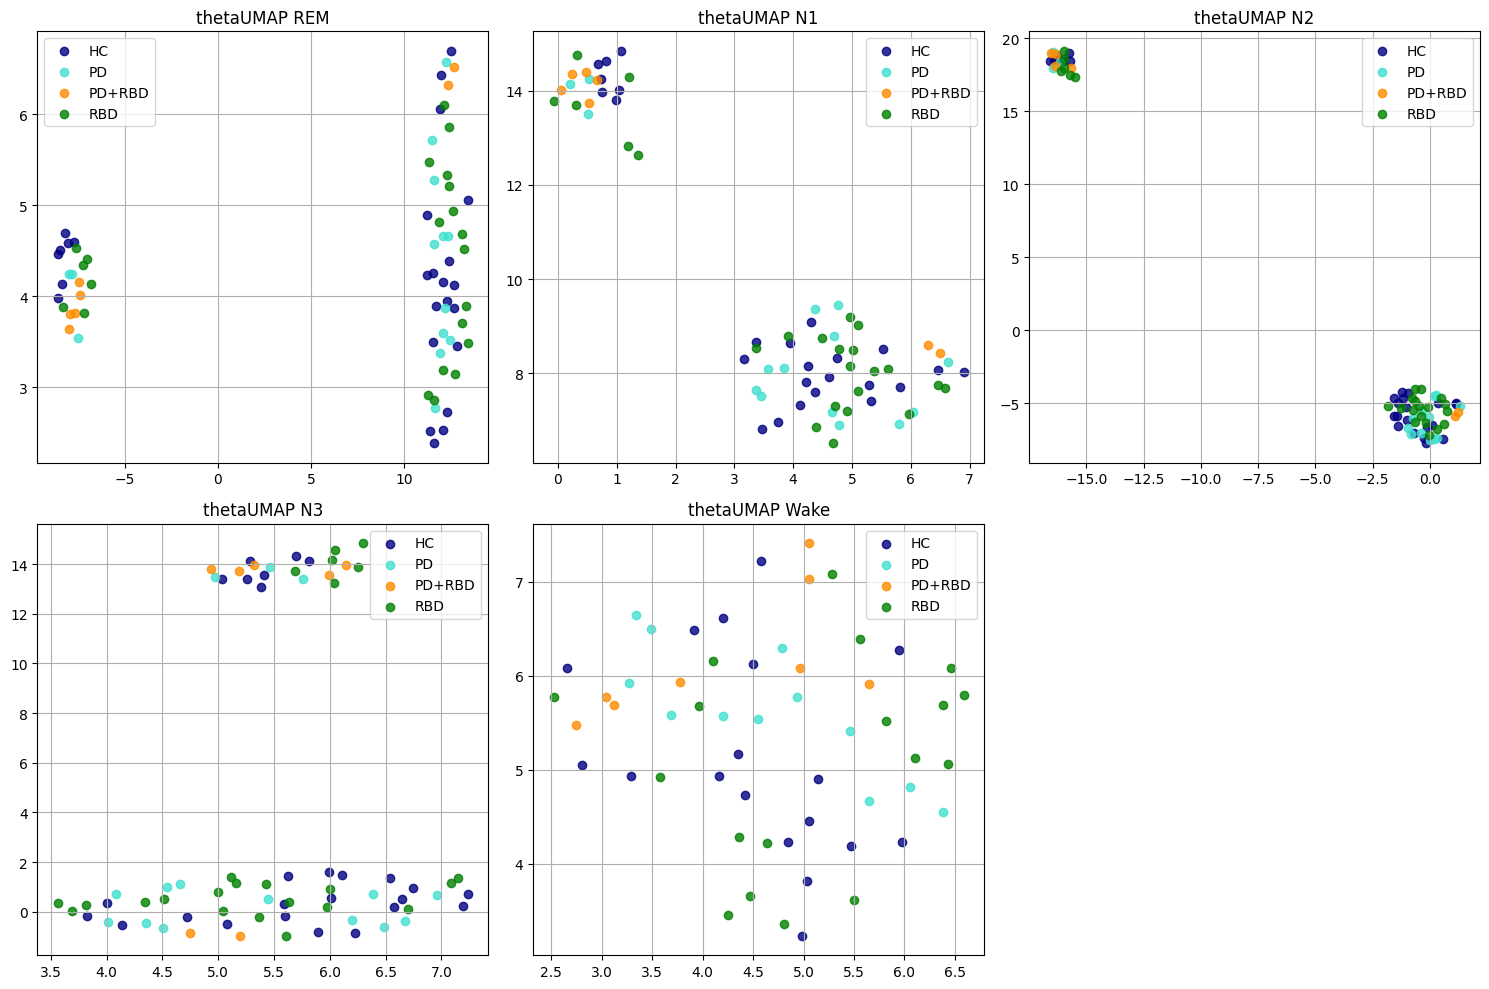

<Figure size 640x480 with 0 Axes>

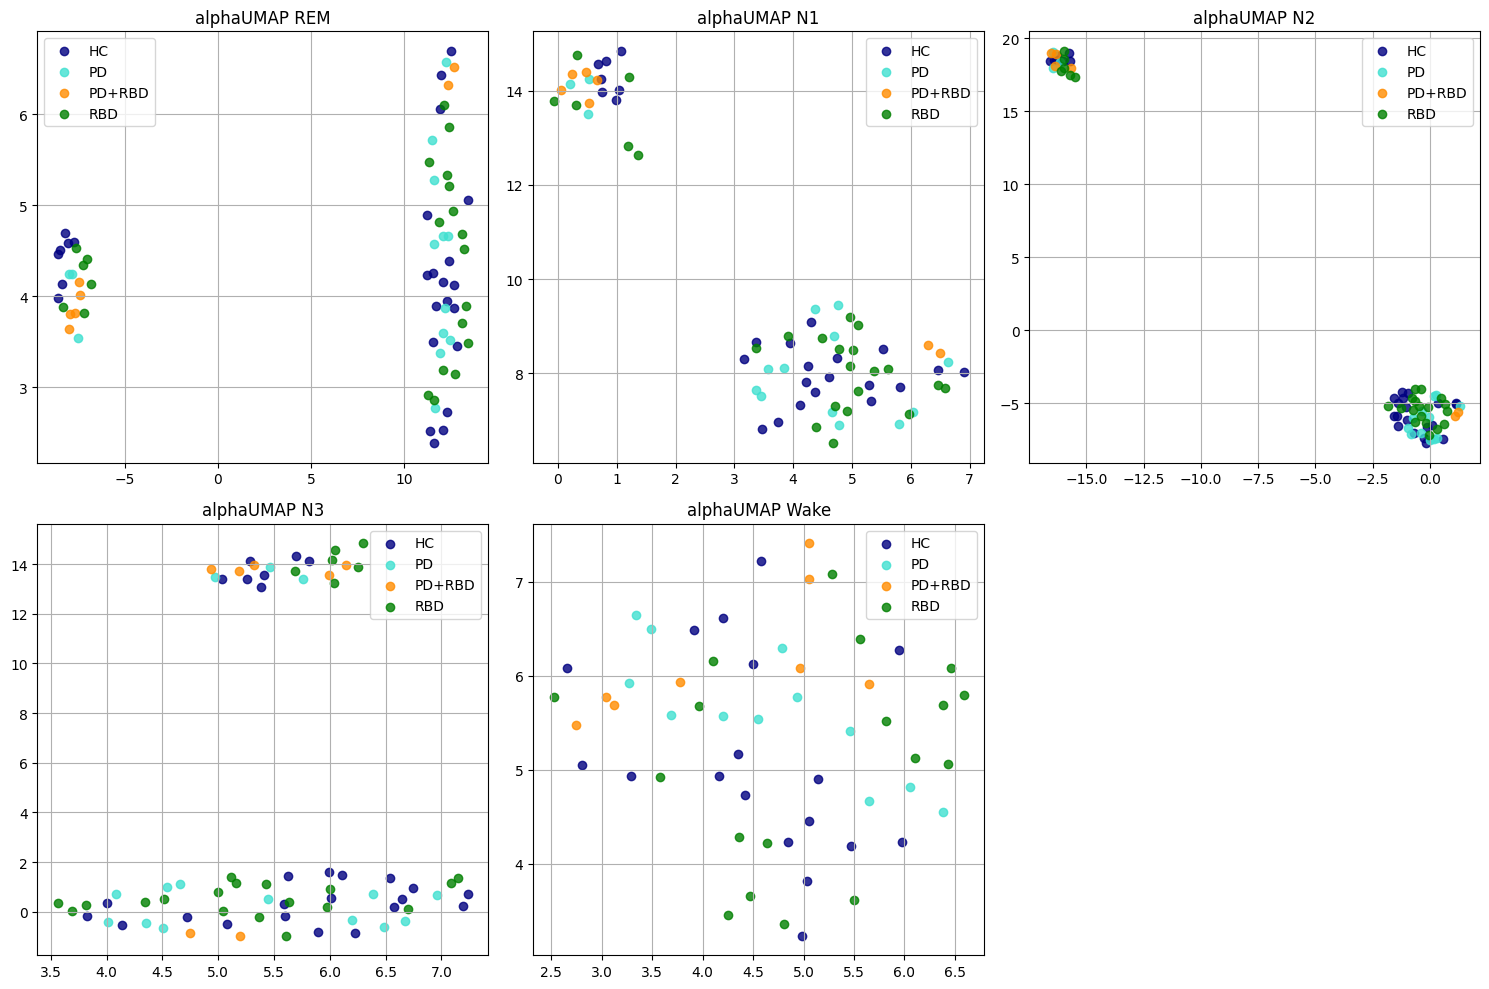

<Figure size 640x480 with 0 Axes>

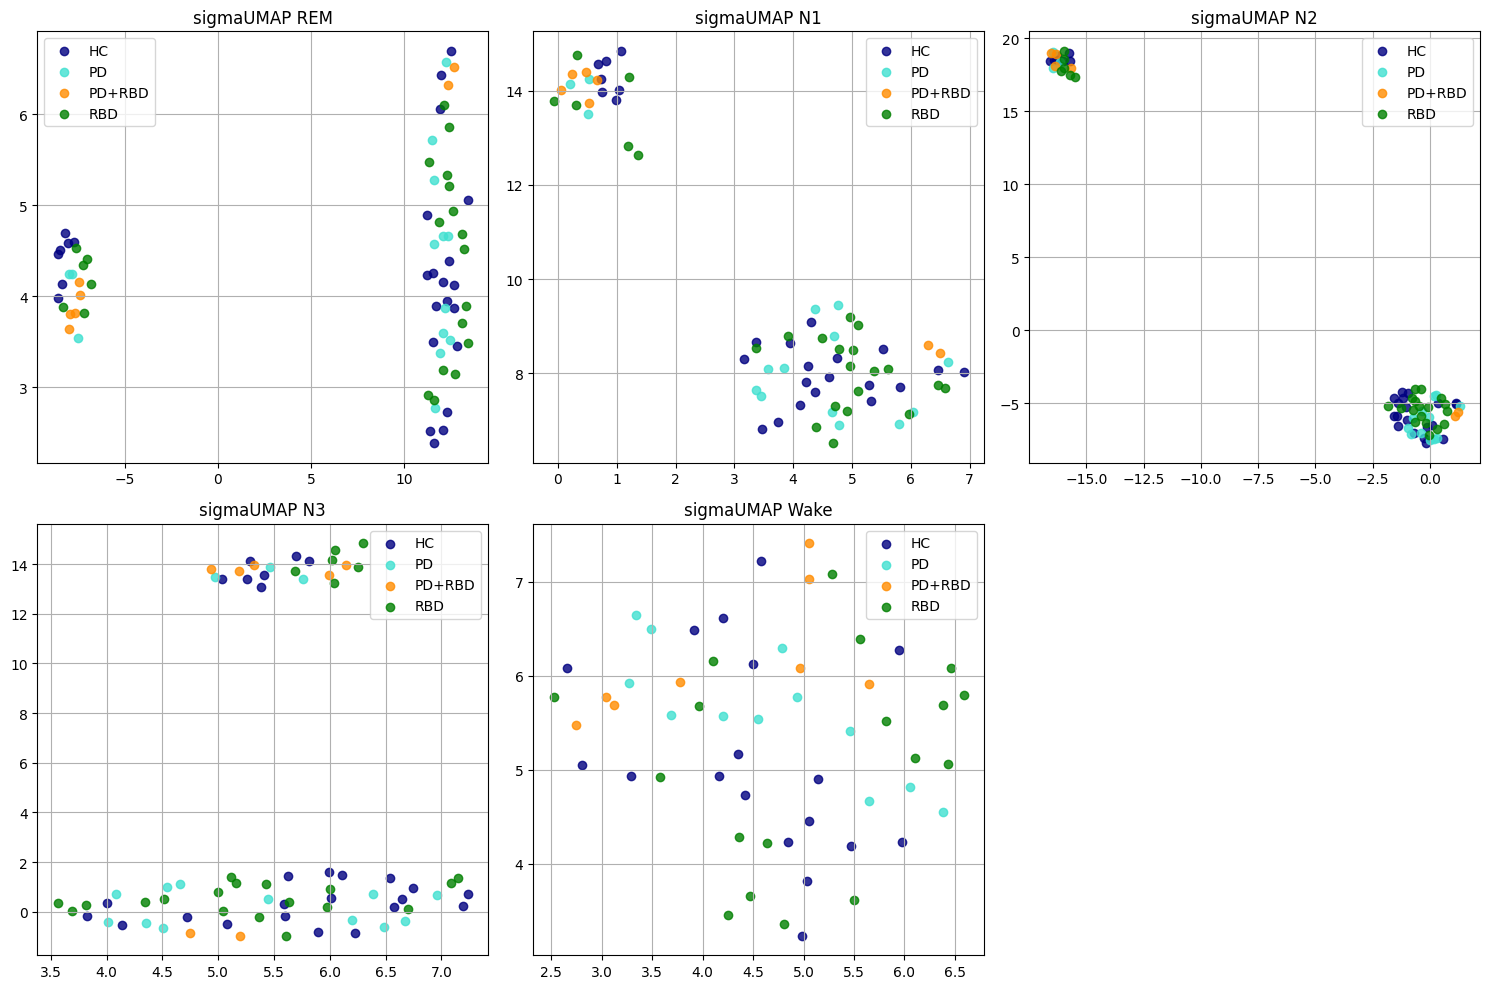

<Figure size 640x480 with 0 Axes>

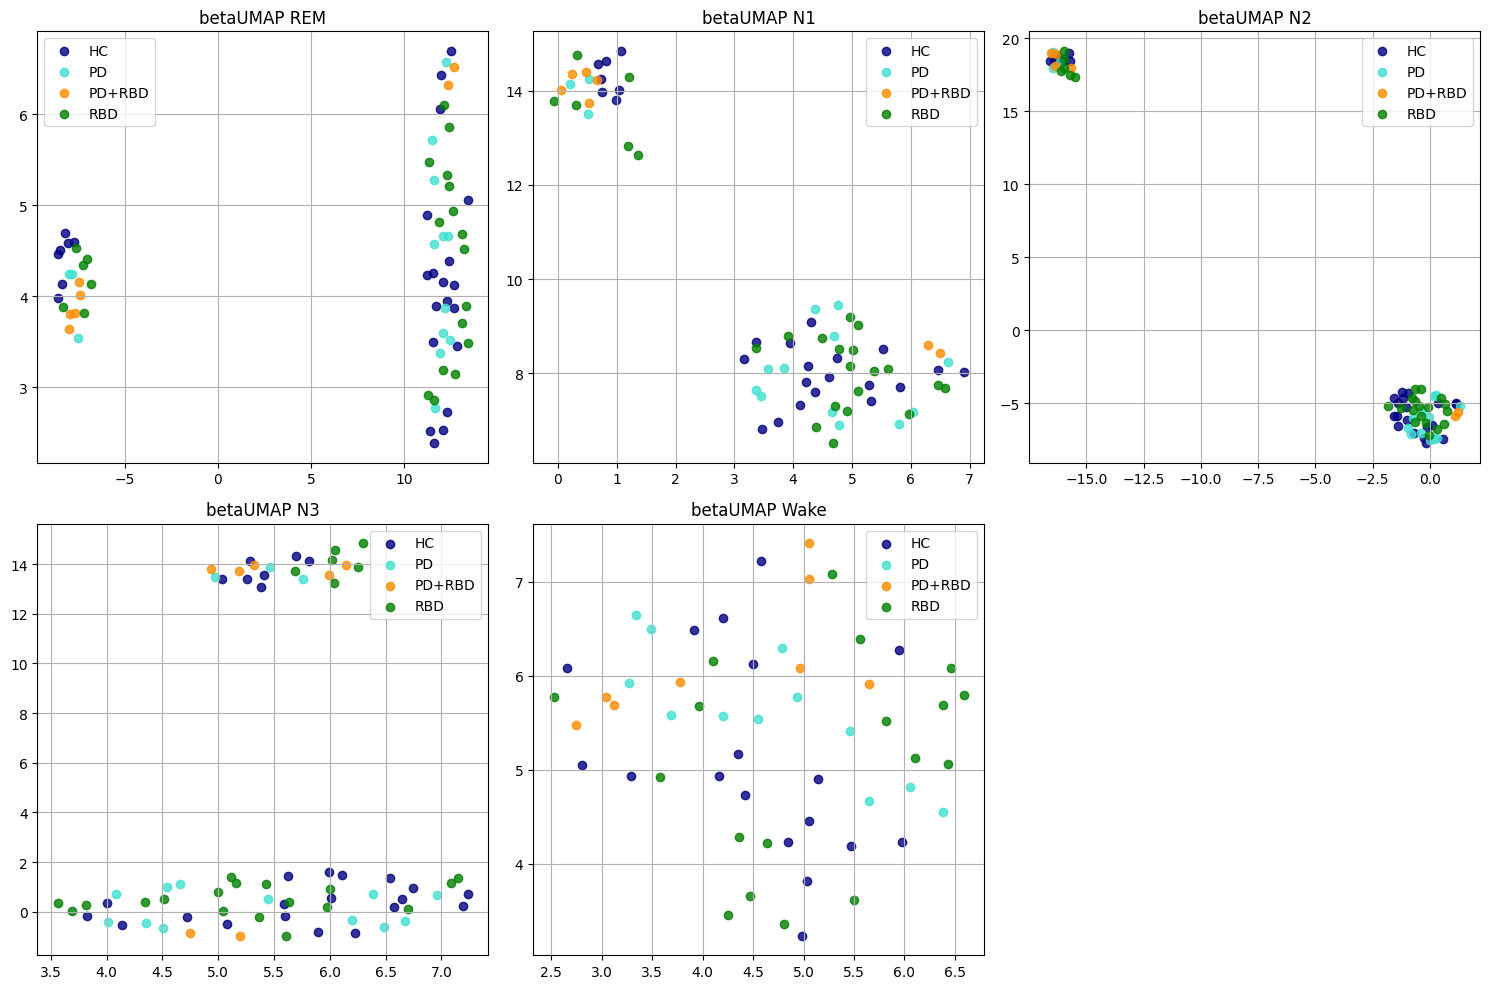

<Figure size 640x480 with 0 Axes>

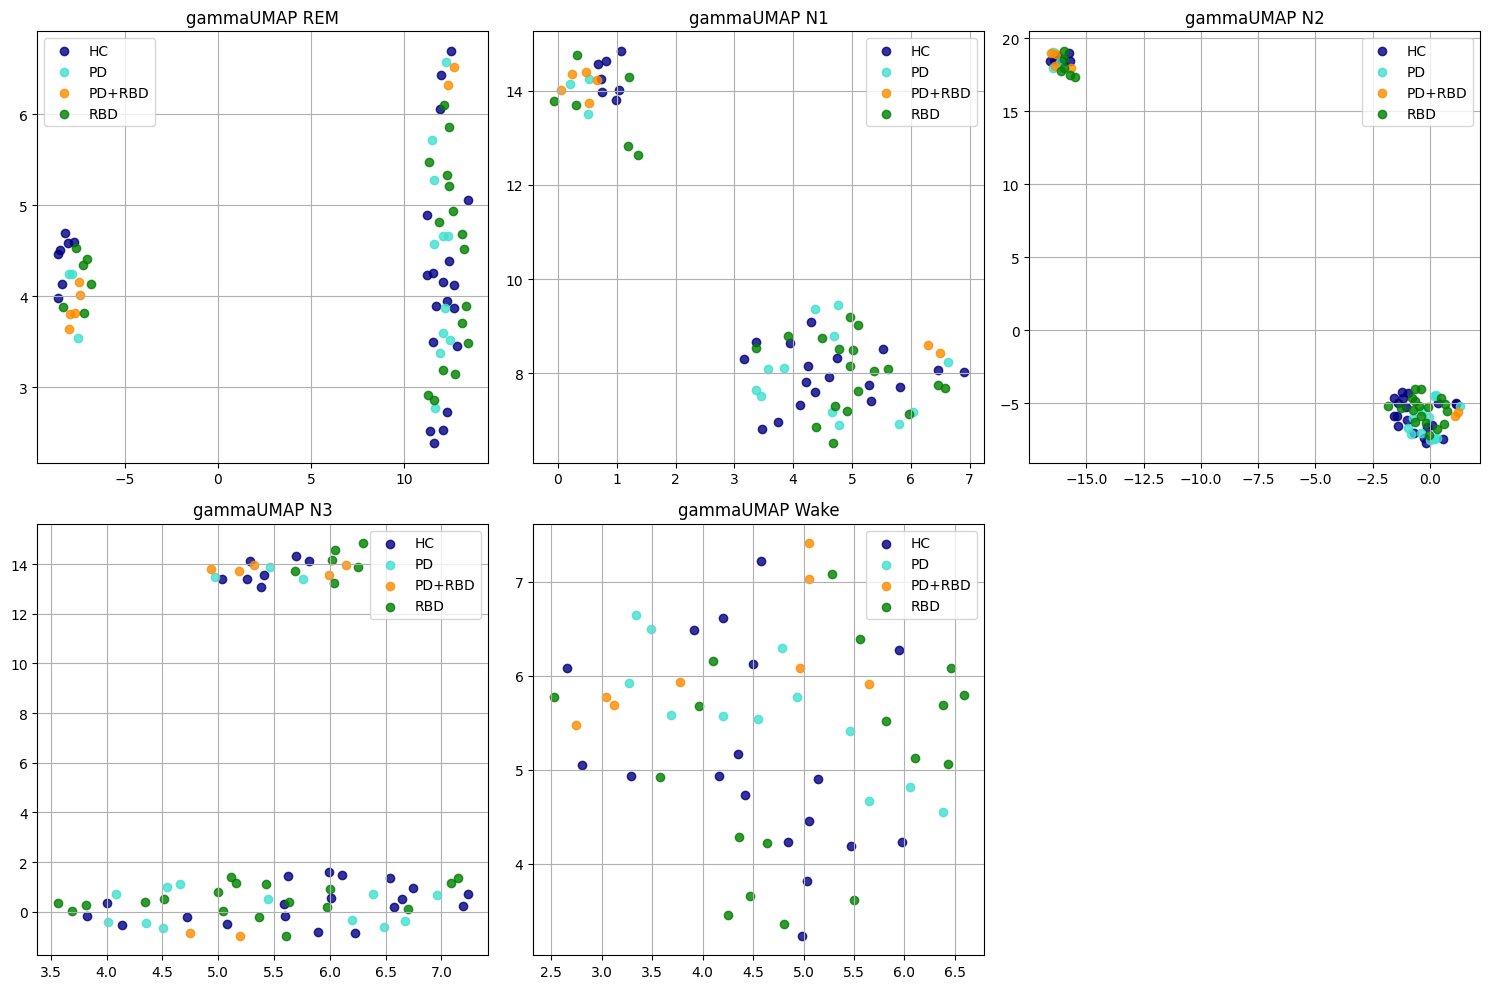

In [15]:
#Plot the graphs for all data types

for power_band in power_band_names:

    fig = plt.figure()
    fig = plt.figure(figsize=(15,10),dpi=100)
    
    colors =  ['navy', 'turquoise', 'darkorange', 'green']
    target_names = ['HC' , 'PD' , 'PD+RBD', 'RBD'] 
    
    for i, data_type in enumerate(['REM', 'N1', 'N2', 'N3', 'Wake']):
        power_bands = {'delta' : (0.5,4) , 'theta' : (4,8) , 'alpha' : (8,12) , 'sigma' : (12,16) , 'beta' : (16,30) , 'gamma' : (30,40) }
        power_band_names = [val for val in power_bands.keys()]
        folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/Connectivity/'
        X = pd.read_hdf(folder + data_type+ '_coherence_df.h5')
        X = X.reset_index(drop = True)
        #Select the power band
        X[[col for col in X.columns if power_band in col]]
        
        y = pd.read_hdf('/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/C_22_data/Full_dfs/' + data_type + '_y.h5')
        groups = pd.read_hdf('/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/C_22_data/Full_dfs/' + data_type + '_groups.h5')
        
        reducer = umap.UMAP(random_state=42)
        
        X_umap = reducer.fit_transform(X)
        
        ax = fig.add_subplot(2,3,i+1)
        
        plt.title(power_band + 'UMAP ' + data_type)
    
        for color, i, target_name in zip(colors, [0, 1, 2,3], target_names):
            plt.scatter(X_umap[y == i, 0], X_umap[y == i, 1], color=color, alpha=0.8, label=target_name)
            plt.legend()
        
        plt.grid()
        
        plt.tight_layout()